In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import sklearn.neighbors
from ast import literal_eval
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from scipy import stats
from two_lists_similarity import Calculate_Similarity as cs
from datetime import timedelta
from numba import jit
from sklearn import linear_model, metrics 
import statsmodels.formula.api as sm
import statsmodels.api as sm
import pandas.util.testing as tm
import pymc3 as pm
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import seaborn as sns
from seaborn import kdeplot

C:\Users\Devashish\Anaconda3_1\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Devashish\Anaconda3_1\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Time snapshots data analysis

In [2]:
# Import trip data
df = pd.read_csv('201503-citibike-tripdata.csv')

# Import bike availability snapshots
snapshot = pd.read_csv('bikeshare_nyc_raw_201503.csv')

# Import subway station information
subways = pd.read_csv('nyc_sub_way_station.csv')

# Subway 2015 ridership data
ridership = pd.read_excel('Subway_ridership_2015.xlsx','Sheet2')
#ridership['station name'] = ridership['station name'].str.replace(r"\(.*\)","")
#ridership = ridership.groupby('station name')['2015_Rides'].sum().reset_index(name='counts')

In [3]:
snapshot[['doc_id','dock_name','date','hour','minute','pm','avail_bikes','avail_docks','tot_docks','lat','long','in_service','status_key']] = snapshot['dock_id\tdock_name\tdate\thour\tminute\tpm\tavail_bikes\tavail_docks\ttot_docks\t_lat\t_long\tin_service\tstatus_key'].str.split('\t',expand=True)
del snapshot['dock_id\tdock_name\tdate\thour\tminute\tpm\tavail_bikes\tavail_docks\ttot_docks\t_lat\t_long\tin_service\tstatus_key']
snapshot['date'] = snapshot.date.apply(literal_eval)

In [4]:
# Convert some of the columns to numeric
cols = ['doc_id','hour','minute','avail_bikes','avail_docks','tot_docks','lat','long','in_service','status_key','pm']
snapshot[cols] = snapshot[cols].apply(pd.to_numeric, errors='coerce')

In [5]:
# Create avariables for bike stockouts and dock stockouts
snapshot['bike_stockout1'] = np.where(snapshot['avail_bikes']==0,1,0)

In [6]:
# Divide the time slots based on Kabra et al. 2016
def update_hour(row):
    if ((row['pm']==1) & (row['hour']==12)):
        updated_hour = 12
    elif ((row['pm']==1) & (row['hour']!=12)):
        updated_hour = row['hour'] + 12
    elif ((row['pm']==0) & (row['hour']==12)):
        updated_hour = 0
    else:
        updated_hour = row['hour']
    return (updated_hour)

In [7]:
# Apply the above function to update the hour based on am or pm
snapshot['updated_hour'] = snapshot.apply(update_hour, axis=1)
#snapshot['updated_minute'] = np.round(snapshot['minute']/60,2)
#snapshot['hourminute'] = snapshot['updated_hour'] + snapshot['updated_minute']
snapshot['updated_date'] = pd.to_datetime(snapshot['date'], format='%y-%m-%d')
snapshot['updated_time'] = pd.to_datetime(snapshot['updated_hour'].astype(str)+':'+snapshot['minute'].astype(str), format='%H:%M').dt.time
# Create the lagged time variables
snapshot['datetime'] = pd.to_datetime(snapshot['updated_date'].astype(str) +" " +snapshot['updated_time'].astype(str))
#snapshot['tminus15min'] = snapshot['datetime'] - timedelta(minutes=15)
#snapshot['tminus20min'] = snapshot['datetime'] - timedelta(minutes=20)
#snapshot['tminus25min'] = snapshot['datetime'] - timedelta(minutes=25)
#snapshot['updated_time'] = pd.to_datetime(snapshot['updated_time'], format ='%H:%M:%S' )

In [8]:
# Indicator variables for time of the day based on Kabra et al. 2016
#snapshot['night'] = np.where(snapshot['hourminute']<=5,1,0)
#snapshot['early morning'] = np.where((snapshot['hourminute']>5) & (snapshot['hourminute']<=8),1,0)
#snapshot['morning rush'] = np.where((snapshot['hourminute']>8) & (snapshot['hourminute']<=12),1,0)
#snapshot['afternoon'] = np.where((snapshot['hourminute']>12) & (snapshot['hourminute']<=16),1,0)
#snapshot['evening'] = np.where((snapshot['hourminute']>16) & (snapshot['hourminute']<=20),1,0)
#snapshot['late evening'] = np.where(snapshot['hourminute']>20 ,1,0)

In [9]:
# Stockouts by time of the day
#stockouts_day = snapshot[snapshot['in_service']==1].groupby(['updated_hour'])['bike_stockout1'].sum().reset_index()
#stockouts_day['percentage of stockouts'] = stockouts_day['bike_stockout1']/np.sum(snapshot[snapshot['in_service']==1]['bike_stockout1'])

# Stockouts by station
#stockouts_dock = snapshot[snapshot['in_service']==1].groupby(['doc_id'])['bike_stockout1'].sum().reset_index()
#stockouts_dock['percentage of stockouts'] = stockouts_dock['bike_stockout1']/np.sum(snapshot[snapshot['in_service']==1]['bike_stockout1'])


In [10]:
# Create a unique list of bike station latitudes and longitudes
bike_locations = pd.read_csv('bike_locations.csv')
# Convert the lat and long to radians
bike_locations[['station lati radians', 'station long radians']] = (np.radians(bike_locations.loc[:, ['lat','long']]))

In [11]:
# Calculate the closest bike stations to each other
dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')
station_dist_matrix = pd.DataFrame(dist.pairwise(bike_locations[['station lati radians', 'station long radians']].to_numpy())*3959,  columns=bike_locations.doc_id.unique(), index=bike_locations.doc_id.unique())
station_dist = station_dist_matrix.where(np.triu(np.ones(station_dist_matrix.shape)).astype(np.bool))
station_dist = station_dist.stack().reset_index()
station_dist.columns = ['doc_id','closest_station_id','closestbike_dist']
station_dist['own'] = np.where(station_dist['doc_id']==station_dist['closest_station_id'], 1, 0)
station_dist['walk_closestbike'] = np.where(station_dist['closestbike_dist']<=0.5,1,0)
station_dist = station_dist[station_dist['own']==0]
closest_station = station_dist.loc[station_dist.groupby('doc_id').closestbike_dist.idxmin()].reset_index(drop=True)
del closest_station['own']

In [12]:
# Combine the closest bike station and the distance to the snapshots
snapshot = pd.merge(snapshot, closest_station, left_on='doc_id', right_on='doc_id', how='left')

In [13]:
# Sort the dataframe by doc id and date
snapshot = snapshot.sort_values(['doc_id','datetime'], ascending=[True,True])
# Create a lagged avalability variable for each doc id
snapshot['avail_bikes.1'] = snapshot.groupby(['doc_id'])['avail_bikes'].shift(-1)
# Create lagged variables for stockout
snapshot['stockout.1'] = snapshot.groupby(['doc_id'])['bike_stockout1'].shift(1)
# Bike station usage
snapshot['usage'] = np.where(snapshot['avail_bikes']>snapshot['avail_bikes.1'], (snapshot['avail_bikes']-snapshot['avail_bikes.1']),0)

In [14]:
# Data for grouping by day and hour of the day
groupsnaps = snapshot[snapshot['in_service']==1][['doc_id','updated_date','updated_hour','avail_bikes','avail_docks','tot_docks','bike_stockout1','closest_station_id',
                      'closestbike_dist','walk_closestbike', 'lat', 'long','usage']]

In [15]:
groupsnaps = groupsnaps.groupby(['doc_id','updated_date','updated_hour'],as_index=True).aggregate({'avail_bikes':'mean','avail_docks':'mean','tot_docks':'mean',
                                                                     'bike_stockout1':'mean','closest_station_id':'mean',
                                                                      'walk_closestbike':'mean','closestbike_dist':'mean','lat':'max','long':'max','usage':'sum'}).reset_index()

In [16]:
# Indicator variables for time of the day based on Kabra et al. 2016
groupsnaps['night'] = np.where(groupsnaps['updated_hour']<=4,1,0)
groupsnaps['early_morning'] = np.where((groupsnaps['updated_hour']>=5) & (groupsnaps['updated_hour']<=7),1,0)
groupsnaps['morning_rush'] = np.where((groupsnaps['updated_hour']>=8) & (groupsnaps['updated_hour']<=10),1,0)
groupsnaps['afternoon'] = np.where((groupsnaps['updated_hour']>=11) & (groupsnaps['updated_hour']<=16),1,0)
groupsnaps['evening'] = np.where((groupsnaps['updated_hour']>=17) & (groupsnaps['updated_hour']<=20),1,0)
groupsnaps['late_evening'] = np.where(groupsnaps['updated_hour']>=21 ,1,0)

In [17]:
# Sort the dataframe by doc id and date
groupsnaps = groupsnaps.sort_values(['doc_id','updated_date','updated_hour'], ascending=[True,True,True])
# Bike availability in the next time shot
groupsnaps['avail_bikes.1'] = groupsnaps.groupby(['doc_id'])['avail_bikes'].shift(-1)
# Bike stockout
groupsnaps['stockout'] = np.where(groupsnaps['bike_stockout1']>=0.3,1,0)
#del groupsnaps['bike_stockout1']
# Bike stockout in the last time period
groupsnaps['stockout.1'] = groupsnaps.groupby(['doc_id'])['stockout'].shift(1)
# Bike station usage
#groupsnaps['usage'] = np.where(groupsnaps['avail_bikes']>groupsnaps['avail_bikes.1'], (groupsnaps['avail_bikes']-groupsnaps['avail_bikes.1']),0)

In [18]:
# Add variable for previous hour stockout at a nearest railway station
groupsnaps1 = pd.merge(groupsnaps, 
                       groupsnaps[['doc_id','updated_date','updated_hour','stockout']], 
                      left_on =['closest_station_id', 'updated_date','updated_hour'], 
                       right_on = ['doc_id', 'updated_date','updated_hour'], how='left')
# Delete the columns not required after merge and rename the new columns
del groupsnaps1['doc_id_y']
groupsnaps1 = groupsnaps1.rename(columns = {'stockout_y':'stockout_closest',
                                            'stockout_x':'stockout',
                                            'doc_id_x':'doc_id'})

In [19]:
groupsnaps1.shape

(234769, 23)

In [20]:
# Read in the list of coordinates from the snapshot file
snapstations = pd.read_csv('stationlocfromsnapshot.csv')

In [21]:
# Closest subway station
snapstations[['station lati radians', 'station long radians']] = (np.radians(snapstations.loc[:, ['lat','long']]))
subways[['subway lati radians', 'subway long radians']] = (np.radians(subways.loc[:, ['sub latitude','sub longitude']]))

dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')

# Calculate the distance matrix
dist_matrix = (dist.pairwise
              (snapstations[['station lati radians', 'station long radians']],
              subways[['subway lati radians', 'subway long radians']]))*3959

# Creating a distance matrix
df_dist_matrix = (
    pd.DataFrame(dist_matrix,index=snapstations['doc_id'], 
                 columns=subways['sub name'])
)

# Unpivot this dataframe from wide format to long format.
# When you unpivot, the data in the pivot table becomes a
# column named 'value'. Rename this column to 'miles' for clarity.
df_dist_long = (
    pd.melt(df_dist_matrix.reset_index(),id_vars='doc_id')
)
df_dist_long = df_dist_long.rename(columns={'value':'sub_dist'})

# Closest subway station for each bike station
closest_subway = df_dist_long.loc[df_dist_long.groupby('doc_id').sub_dist.idxmin()].reset_index(drop=True)

In [22]:
# Read in the file containing bike station agglomeration around subway
subagglom = pd.read_csv('subagglom.csv')

In [23]:
# Combine the closest subway information with the grouped snapshot data
groupsnaps1 = pd.merge(groupsnaps1, closest_subway, left_on = 'doc_id', right_on = 'doc_id', how='left')
#groupsnaps1 = pd.merge(groupsnaps1, subagglom, left_on='sub name', right_on='sub name',how='left')
groupsnaps1['sub_walk2'] = np.where(groupsnaps1['sub_dist']<=0.2,1,0)
groupsnaps1['sub_walk3'] = np.where(groupsnaps1['sub_dist']<=0.3,1,0)
groupsnaps1['sub_walk4'] = np.where(groupsnaps1['sub_dist']<=0.4,1,0)

In [24]:
groupsnaps1.shape

(234769, 28)

In [25]:
# Read in the weather related data for March 2015
all_weather = pd.read_excel('March2015weather.xlsx', sheet_name = None)
weather = pd.concat(all_weather, ignore_index=True)
weather['hour'] = weather['Time'].astype('str').str[:2].astype(int)
weather['temp'] = weather['Temperature'].astype('str').str[:-1].astype(float)
weather['precip'] = weather['Precip.'].astype('str').str[:-2].astype(float)
weather = weather[['hour','Date','temp','precip']].groupby(['hour','Date']).agg({'temp':'mean','precip':'mean'}).reset_index()

In [26]:
# Add temp and precipitation information to the grouped snapshot file
groupsnaps1 = pd.merge(groupsnaps1, weather, 
                       left_on=['updated_date','updated_hour'],
                       right_on = ['Date','hour'], how='left')
del groupsnaps1['Date']
del groupsnaps1['hour']
groupsnaps1 = groupsnaps1.dropna()
groupsnaps1 = groupsnaps1.reset_index()
groupsnaps1 = groupsnaps1.rename(columns = {'stockout.1':'stockout_1','stockout.2':'stockout_2','stockout.3':'stockout_3','stockout.4':'stockout_4','stockout.5':'stockout_5','stockout.6':'stockout_6','stockout.7':'stockout_7'})
groupsnaps1 = pd.merge(groupsnaps1, ridership, left_on = 'sub name', right_on = 'sub name', how = 'left')
groupsnaps1 = groupsnaps1.rename(columns = {'Sum of 2015_Rides':'subway_ridership'})

In [27]:
groupsnaps1.shape

(223913, 32)

In [28]:
# Convert to date type object in the transactions data
df['starttime'] = pd.to_datetime(df['starttime']) 
df['stoptime'] = pd.to_datetime(df['stoptime']) 

# Extract the start and stop hour in the transactions data
df['starthour'] = df['starttime'].dt.hour
df['stophour'] = df['stoptime'].dt.hour

# Calculate arrival and departure dominant bike stations by time of day
departures = df[['start station id','starthour']].groupby(['start station id','starthour']).size().reset_index()
departures = departures.rename(columns = {0:'departures','start station id':'doc_id','starthour':'updated_hour'})
arrivals = df[['end station id','stophour']].groupby(['end station id','stophour']).size().reset_index()
arrivals = arrivals.rename(columns = {0:'arrivals','end station id':'doc_id','stophour':'updated_hour'})
deparr = pd.merge(departures, arrivals, left_on = ['doc_id','updated_hour'], right_on = ['doc_id','updated_hour'], how = 'left')
deparr['depdom'] = np.where(deparr['departures']>deparr['arrivals'],1,0)

In [29]:
transactions = df.groupby('starthour').size().reset_index()
transactions = transactions.rename(columns = {0:'usage'})

C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


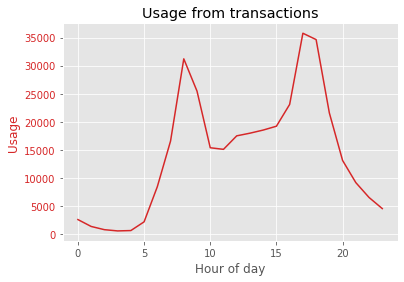

In [30]:
# Set up the pyplot with two axes
fig, ax0 = plt.subplots()
color = 'tab:red'
ax0.set_title('Usage from transactions')
ax0.set_xlabel('Hour of day')
ax0.set_ylabel('Usage', color=color)
ax0.plot(transactions['starthour'], transactions['usage'], color=color)
ax0.tick_params(axis='y', labelcolor=color)

In [31]:
# Add transaction related information for each hour
groupsnaps1 = pd.merge(groupsnaps1, deparr, left_on = ['doc_id','updated_hour'], right_on = ['doc_id','updated_hour'], how = 'left')

In [32]:
groupsnaps1.shape

(223913, 35)

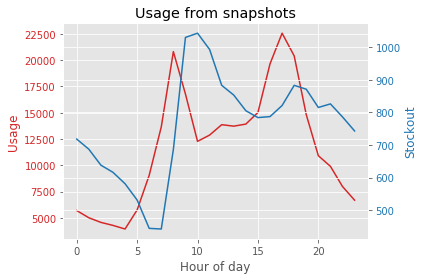

In [33]:
avgusage = groupsnaps1.groupby('updated_hour', as_index = False)['usage'].sum().reset_index()
avgstockout = groupsnaps1.groupby('updated_hour', as_index = False)['stockout'].sum().reset_index()
total = pd.merge(avgusage, avgstockout, left_on = 'updated_hour', right_on = 'updated_hour', how = 'left')

# Set up the pyplot with two axes
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_title('Usage from snapshots')
ax1.set_xlabel('Hour of day')
ax1.set_ylabel('Usage', color=color)
ax1.plot(total['updated_hour'], total['usage'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Stockout', color=color)  # we already handled the x-label with ax1
ax2.plot(total['updated_hour'], total['stockout'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


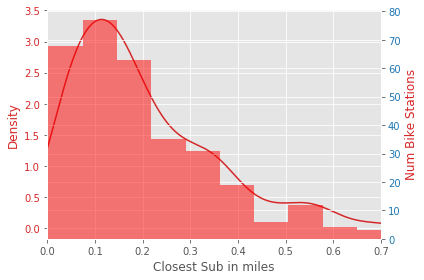

In [34]:
# Data for sub way distance plot analysis
subwalkstockout = groupsnaps1.groupby('sub_dist', as_index = False)['stockout'].mean()

# Set up the pyplot with two axes
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlim([0,0.7])
ax1.set_xlabel('Closest Sub in miles')
ax1.set_ylabel('Density', color=color)
subwalkstockout['sub_dist'].plot.kde(color='tab:red')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'tab:blue'
ax2.set_ylabel('Num Bike Stations', color='tab:red')  # we already handled the x-label with ax1
ax2.hist(subwalkstockout['sub_dist'], color='tab:red', ls="dotted",fc=(1, 0, 0, 0.5))
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

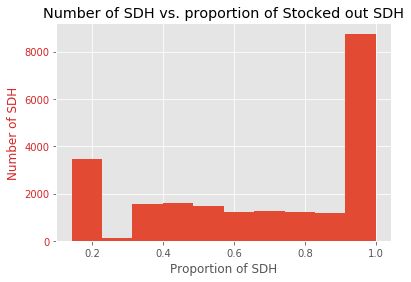

In [35]:
fig, ax0 = plt.subplots()
color = 'tab:red'
ax0.set_title('Number of SDH vs. proportion of Stocked out SDH')
ax0.set_xlabel('Proportion of SDH')
ax0.set_ylabel('Number of SDH', color=color)
groupsnaps1[groupsnaps1['bike_stockout1']>0]['bike_stockout1'].hist()
ax0.tick_params(axis='y', labelcolor=color)


In [36]:
# Data for a predictive model
mlmodel = groupsnaps1[groupsnaps1['stockout']==0].dropna()
stockedout = groupsnaps1[groupsnaps1['stockout']==1].dropna()
X = mlmodel[['avail_bikes','avail_docks','tot_docks','walk_closestbike','closestbike_dist','updated_hour','avail_bikes.1','stockout_1','stockout_closest','sub_dist','sub_walk3','temp','precip','depdom']]
y = mlmodel[['usage']].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13)

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
X_stockedout = stockedout[['avail_bikes','avail_docks','tot_docks','walk_closestbike','closestbike_dist','updated_hour','avail_bikes.1','stockout_1','stockout_closest','sub_dist','sub_walk3','temp','precip','depdom']]
y_stockedout = stockedout[['usage']].values


In [37]:
stockedout.shape

(15400, 35)

In [38]:
# Fit a regression tree and calculate the MSE
regtrees = ensemble.GradientBoostingRegressor(**params)
regtrees.fit(X_train, y_train)
msetrees = mean_squared_error(y_test, regtrees.predict(X_test))
print("The mean squared error (MSE) on test set with reg trees: {:.4f}".format(msetrees))
maetrees = mean_absolute_error(y_test, regtrees.predict(X_test))
print("The absolute squared error (MSE) on test set with reg trees: {:.4f}".format(maetrees))

C:\Users\Devashish\Anaconda3_1\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The mean squared error (MSE) on test set with reg trees: 2.3706
The absolute squared error (MSE) on test set with reg trees: 0.9712


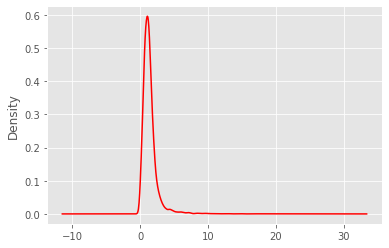

In [39]:
usage_test = pd.DataFrame(y_test)
usage_test = usage_test.rename(columns = {0:'Actual Usage'})
predicted_test = pd.DataFrame(regtrees.predict(X_test))
predicted_test = predicted_test.rename(columns = {0:'Predicted Usage'})

#compare = pd.DataFrame({'Actual usage':y_test.tolist(),'Predicted usage':np.ceil(regtrees.predict(X_test))})
#compare.plot.kde()

predicted_test['Predicted Usage'].plot.kde(label = 'Predicted usage on test', color='red')

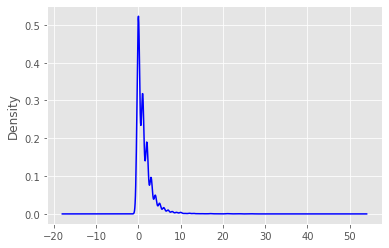

In [40]:
usage_test['Actual Usage'].plot.kde(label = 'Actual usage on test',color='blue')

In [41]:
# Nodel count
regtrees.feature_importances_

array([3.12202995e-01, 2.28684514e-03, 1.84834218e-02, 9.41634535e-05,
       2.91755990e-03, 5.51886677e-02, 5.55689887e-01, 6.04554339e-06,
       4.57464825e-04, 5.25203918e-03, 0.00000000e+00, 1.34786578e-02,
       5.55316635e-03, 2.83890872e-02])

In [42]:
# Fit a least square regression and calculate the MSE
linreg = LinearRegression()
linreg.fit(X_train, y_train)
mseols = mean_squared_error(y_test, linreg.predict(X_test))
print("The mean squared error (MSE) on test set with OLS: {:.4f}".format(mseols))
maeols = mean_absolute_error(y_test, linreg.predict(X_test))
print("The mean absolute error (MSE) on test set with OLS: {:.4f}".format(maeols))

The mean squared error (MSE) on test set with OLS: 3.2581
The mean absolute error (MSE) on test set with OLS: 1.1802


In [43]:
# Fit a PLS regression and calculate MSE
pls = PLSRegression(n_components = 2)
pls.fit(X_train, y_train)
msepls = mean_squared_error(y_test, pls.predict(X_test))
print("The mean squared error (MSE) on test set with PLS: {:.4f}".format(msepls))
maepls = mean_absolute_error(y_test, pls.predict(X_test))
print("The mean absolute error (MSE) on test set with PLS: {:.4f}".format(maepls))

The mean squared error (MSE) on test set with PLS: 4.4089
The mean absolute error (MSE) on test set with PLS: 1.2984


In [44]:
# Fit a random forest regression
rf = RandomForestRegressor(max_depth = 4, random_state = 0, n_estimators = 500, min_samples_leaf = 5)
rf.fit(X_train, y_train)
mserf = mean_squared_error(y_test, rf.predict(X_test))
print("The mean squared error (MSE) on test set with RandomForest: {:.4f}".format(mserf))
maerf = mean_absolute_error(y_test, rf.predict(X_test))
print("The mean absolute error (MSE) on test set with OLS: {:.4f}".format(maerf))

C:\Users\Devashish\Anaconda3_1\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


The mean squared error (MSE) on test set with RandomForest: 3.2808
The mean absolute error (MSE) on test set with OLS: 1.1757


In [45]:
# Fit a negative binomial model
import statsmodels.api as sm
nb = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial()).fit()
msenb = mean_squared_error(y_test, nb.predict(X_test))
print("The mean squared error (MSE) on test set with NegBinomial: {:.4f}".format(msenb))

The mean squared error (MSE) on test set with NegBinomial: 54.1227


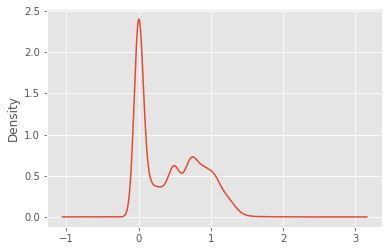

In [48]:
# Demand pediction on the stocked out data
prediction = pd.DataFrame(regtrees.predict(X_stockedout)).reset_index()
prediction = prediction.rename(columns={0:'pred_usage'})
prediction= pd.concat([prediction.reset_index(drop=True), stockedout.reset_index(drop=True)], axis=1)
prediction['lostdemand'] = np.where(prediction['pred_usage']>prediction['usage'],prediction['pred_usage']-prediction['usage'],0)
prediction['lostdemand1'] = np.ceil(prediction['lostdemand'])
prediction['lostdemand'].plot.kde()

In [49]:
# Get the bike availability and arrivals of the closest station and its closest subway
prediction = pd.merge(prediction, groupsnaps1[['updated_date','updated_hour','avail_bikes','doc_id','sub name','arrivals']], 
                      left_on = ['updated_date','updated_hour','closest_station_id'],
                     right_on = ['updated_date','updated_hour','doc_id'], how='left')
del prediction['doc_id_y']
prediction = prediction.rename(columns = {'doc_id_x':'doc_id','avail_bikes_x':'avail_bikes','avail_bikes_y':'closest_avail_bikes','sub name_x':'sub name','sub name_y':'closest_station_sub','arrivals_x':'arrivals','arrivals_y':'closest_station_arrivals'})
#prediction['share_sub'] = np.where(prediction['sub name']==prediction['closest_station_sub'],1,0)

In [50]:
prediction[prediction['lostdemand']>0].shape

(10195, 42)

In [51]:
numlost = prediction[(prediction['lostdemand1']>0)].shape[0]
posssal = prediction[(prediction['lostdemand1']>0) & (prediction['closest_avail_bikes']>prediction['lostdemand1']+1)].shape[0]
print("Lost demand is: "+str(numlost)+" and salvageable demand is: "+str(posssal))

Lost demand is: 10195 and salvageable demand is: 5693


C:\Users\Devashish\Anaconda3_1\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert 

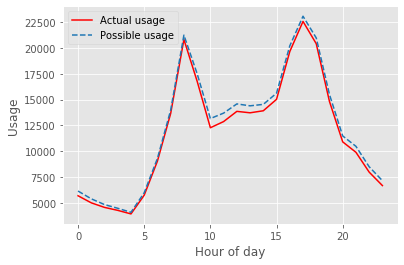

In [52]:
# Lost demand vs. actual observed demand
groupsnaps2 = pd.merge(groupsnaps1, 
                       prediction[['doc_id','updated_date','updated_hour','lostdemand1','closest_avail_bikes','closest_station_arrivals']],
                      left_on = ['doc_id','updated_date','updated_hour'],
                      right_on = ['doc_id','updated_date','updated_hour'],
                      how = 'left').drop_duplicates()
groupsnaps2['lostdemand1'] = groupsnaps2['lostdemand1'].fillna(0)
groupsnaps2['closest_avail_bikes'] = groupsnaps2['closest_avail_bikes'].fillna(0)
groupsnaps2['closest_station_arrivals'] = groupsnaps2['closest_station_arrivals'].fillna(0)

groupsnaps2['possible_usage'] = groupsnaps2['usage'] + groupsnaps2['lostdemand1']
groupsnaps2['stockout_new'] = np.where(groupsnaps2['lostdemand1']>0,1,0)
groupsnaps3 = groupsnaps2.groupby('updated_hour')['possible_usage','usage','lostdemand1'].sum().reset_index()

# Plot the actual and possible usage by the hour of the day
plt.plot(groupsnaps3['updated_hour'], groupsnaps3['usage'], color='red', label='Actual usage')
plt.plot(groupsnaps3['updated_hour'], groupsnaps3['possible_usage'], color='tab:blue',label='Possible usage',linestyle='dashed')
plt.xlabel('Hour of day')
plt.ylabel('Usage')
plt.legend()


C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


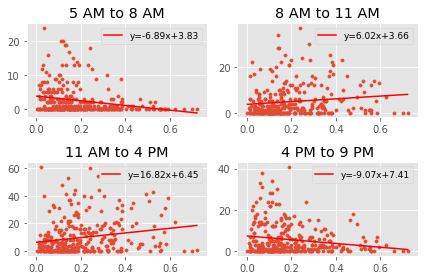

In [53]:
morningstockout1 = groupsnaps2[groupsnaps2['early_morning']==1].groupby('sub_dist').agg({'stockout_new':'sum','subway_ridership':'mean'}).reset_index() #1
morningrushstockout1 = groupsnaps2[groupsnaps2['morning_rush']==1].groupby('sub_dist').agg({'stockout_new':'sum','subway_ridership':'mean'}).reset_index() #2
afternoonstockout1 = groupsnaps2[groupsnaps2['afternoon']==1].groupby('sub_dist').agg({'stockout_new':'sum','subway_ridership':'mean'}).reset_index()# 3
eveningstockout1 = groupsnaps2[groupsnaps2['evening']==1].groupby('sub_dist').agg({'stockout_new':'sum','subway_ridership':'mean'}).reset_index()# 4

a, b = 0, 1

min1, max1 = morningstockout1['subway_ridership'].min(), morningstockout1['subway_ridership'].max()
morningstockout1['Scaled_ridership'] = (morningstockout1['subway_ridership'] - min1) / (max1 - min1) * (b - a) + a
z1 = morningstockout1['Scaled_ridership']

min2, max2 = morningrushstockout1['subway_ridership'].min(), morningrushstockout1['subway_ridership'].max()
morningrushstockout1['Scaled_ridership'] = (morningrushstockout1['subway_ridership'] - min2) / (max2 - min2) * (b - a) + a
z2 = morningrushstockout1['Scaled_ridership']

min3, max3 = afternoonstockout1['subway_ridership'].min(), afternoonstockout1['subway_ridership'].max()
afternoonstockout1['Scaled_ridership'] = (afternoonstockout1['subway_ridership'] - min3) / (max3 - min3) * (b - a) + a
z3 = afternoonstockout1['Scaled_ridership']

min4, max4 = eveningstockout1['subway_ridership'].min(), eveningstockout1['subway_ridership'].max()
eveningstockout1['Scaled_ridership'] = (eveningstockout1['subway_ridership'] - min4) / (max4 - min4) * (b - a) + a
z4 = eveningstockout1['Scaled_ridership']


x1 = morningstockout1['sub_dist']
y1 = morningstockout1['stockout_new']

x2 = morningrushstockout1['sub_dist']
y2 = morningrushstockout1['stockout_new']

x3 = afternoonstockout1['sub_dist']
y3 = afternoonstockout1['stockout_new']

x4 = eveningstockout1['sub_dist']
y4 = eveningstockout1['stockout_new']

slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)
slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(x3,y3)
slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(x4,y4)

fig, axs = plt.subplots(2,2)
line1 = slope1*x1+intercept1
axs[0,0].plot(x1, line1, 'r', label='y={:.2f}x+{:.2f}'.format(slope1,intercept1))
axs[0,0].scatter(x1, y1 ,s=10.5, cmap='viridis_r')
axs[0,0].legend(fontsize=9)
axs[0,0].set_title('5 AM to 8 AM')

line2 = slope2*x2+intercept2
axs[0,1].plot(x2, line2, 'r', label='y={:.2f}x+{:.2f}'.format(slope2,intercept2))
axs[0,1].scatter(x2, y2, s=10.5, cmap='viridis_r')
axs[0,1].legend(fontsize=9)
axs[0,1].set_title('8 AM to 11 AM')


line3 = slope3*x3+intercept3
axs[1,0].plot(x3, line3, 'r', label='y={:.2f}x+{:.2f}'.format(slope3,intercept3))
axs[1,0].scatter(x3, y3, s=10.5, cmap='viridis_r')
axs[1,0].legend(fontsize=9)
axs[1,0].set_title('11 AM to 4 PM')


line4 = slope4*x4+intercept4
axs[1,1].plot(x4, line4, 'r', label='y={:.2f}x+{:.2f}'.format(slope4,intercept4))
axs[1,1].scatter(x4, y4, s=10.5, cmap='viridis_r')
axs[1,1].legend(fontsize=9)
axs[1,1].set_title('4 PM to 9 PM')

fig.tight_layout()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


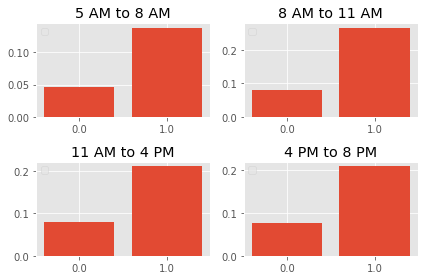

In [54]:
morningstockout2 = groupsnaps1[groupsnaps1['early_morning']==1].groupby('stockout_closest')['stockout'].mean().reset_index() #1
morningstockout2['stockout_closest'] = morningstockout2['stockout_closest'].astype(str)

morningrushstockout2 = groupsnaps1[groupsnaps1['morning_rush']==1].groupby('stockout_closest')['stockout'].mean().reset_index() #2
morningrushstockout2['stockout_closest'] = morningrushstockout2['stockout_closest'].astype(str)

afternoonstockout2 = groupsnaps1[groupsnaps1['afternoon']==1].groupby('stockout_closest')['stockout'].mean().reset_index()# 3
afternoonstockout2['stockout_closest'] = afternoonstockout2['stockout_closest'].astype(str)

eveningstockout2 = groupsnaps1[groupsnaps1['evening']==1].groupby('stockout_closest')['stockout'].mean().reset_index()# 4
eveningstockout2['stockout_closest'] = eveningstockout2['stockout_closest'].astype(str)


fig, axs = plt.subplots(2,2)
axs[0,0].bar(morningstockout2['stockout_closest'], morningstockout2['stockout'])
axs[0,0].legend(fontsize=9)
axs[0,0].set_title('5 AM to 8 AM')

axs[0,1].bar(morningrushstockout2['stockout_closest'], morningrushstockout2['stockout'])
axs[0,1].legend(fontsize=9)
axs[0,1].set_title('8 AM to 11 AM')

axs[1,0].bar(afternoonstockout2['stockout_closest'], afternoonstockout2['stockout'])
axs[1,0].legend(fontsize=9)
axs[1,0].set_title('11 AM to 4 PM')

axs[1,1].bar(eveningstockout2['stockout_closest'], eveningstockout2['stockout'])
axs[1,1].legend(fontsize=9)
axs[1,1].set_title('4 PM to 8 PM')

plt.subplots_adjust(wspace=0.4, hspace=0.4)
fig.tight_layout()

In [55]:
groupsnaps1.shape

(223913, 35)

In [56]:
groupsnaps2.shape

(223913, 40)

C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


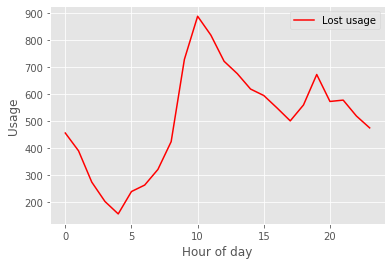

In [57]:
# Plot the lostdemand by hour of the day
plt.plot(groupsnaps3['updated_hour'], groupsnaps3['lostdemand1'], color='red', label='Lost usage')
plt.xlabel('Hour of day')
plt.ylabel('Usage')
plt.legend()

In [58]:
groupsnaps2.columns

Index(['index', 'doc_id', 'updated_date', 'updated_hour', 'avail_bikes',
       'avail_docks', 'tot_docks', 'bike_stockout1', 'closest_station_id',
       'walk_closestbike', 'closestbike_dist', 'lat', 'long', 'usage', 'night',
       'early_morning', 'morning_rush', 'afternoon', 'evening', 'late_evening',
       'avail_bikes.1', 'stockout', 'stockout_1', 'stockout_closest',
       'sub name', 'sub_dist', 'sub_walk2', 'sub_walk3', 'sub_walk4', 'temp',
       'precip', 'subway_ridership', 'departures', 'arrivals', 'depdom',
       'lostdemand1', 'closest_avail_bikes', 'closest_station_arrivals',
       'possible_usage', 'stockout_new'],
      dtype='object')

In [59]:
groupsnaps2['walk_closestbike']=np.where(groupsnaps2['closestbike_dist']<=0.35,1,0)

In [60]:
# Add the closest subway agglomeration
groupsnaps2 = pd.merge(groupsnaps2, subagglom, left_on = 'sub name', right_on = 'sub name', how='left')
groupsnaps2['higherclosest'] = np.where(groupsnaps2['closest_station_arrivals']>groupsnaps2['arrivals'],groupsnaps2['closest_station_arrivals']-groupsnaps2['arrivals'],0 )
groupsnaps2['lowerclosest'] = np.where(groupsnaps2['closest_station_arrivals']<groupsnaps2['arrivals'],groupsnaps2['closest_station_arrivals']<groupsnaps2['arrivals'],0 )

In [61]:
groupsnaps2.shape

(223913, 47)

In [62]:
stationagglom = pd.read_csv('stationagglom.csv')

In [63]:
# Add the bike station agglomeration
groupsnaps2 = pd.merge(groupsnaps2,stationagglom, left_on = 'doc_id', right_on = 'doc_id',how = 'left' )

In [64]:
groupsnaps2.shape

(223913, 52)

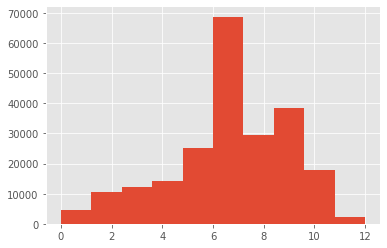

In [65]:
groupsnaps2['stationagglom3'].hist() # Bike station agglomeration

C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


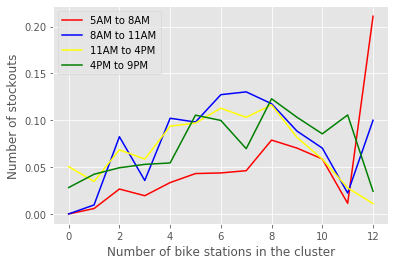

In [66]:
stationagglom_morning = groupsnaps2[groupsnaps2['early_morning']==1].groupby(['stationagglom3']).agg({'stockout':'mean'}).reset_index()
stationagglom_rush = groupsnaps2[groupsnaps2['morning_rush']==1].groupby(['stationagglom3']).agg({'stockout':'mean'}).reset_index()
stationagglom_afternoon = groupsnaps2[groupsnaps2['afternoon']==1].groupby(['stationagglom3']).agg({'stockout':'mean'}).reset_index()
stationagglom_evening = groupsnaps2[groupsnaps2['evening']==1].groupby(['stationagglom3']).agg({'stockout':'mean'}).reset_index()

plt.plot(stationagglom_morning['stationagglom3'], stationagglom_morning['stockout'], color='red', label='5AM to 8AM')
plt.plot(stationagglom_rush['stationagglom3'], stationagglom_rush['stockout'], color='blue', label='8AM to 11AM')
plt.plot(stationagglom_afternoon['stationagglom3'], stationagglom_afternoon['stockout'], color='yellow', label='11AM to 4PM')
plt.plot(stationagglom_evening['stationagglom3'], stationagglom_evening['stockout'], color='green', label='4PM to 9PM')

plt.xlabel('Number of bike stations in the cluster')
plt.ylabel('Number of stockouts')
plt.legend()


C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


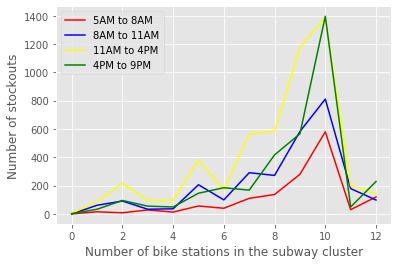

In [67]:
subagglom_morning = groupsnaps2[groupsnaps2['early_morning']==1].groupby(['agglom3']).agg({'stockout':'sum'}).reset_index()
subagglom_rush = groupsnaps2[groupsnaps2['morning_rush']==1].groupby(['agglom3']).agg({'stockout':'sum'}).reset_index()
subagglom_afternoon = groupsnaps2[groupsnaps2['afternoon']==1].groupby(['agglom3']).agg({'stockout':'sum'}).reset_index()
subagglom_evening = groupsnaps2[groupsnaps2['evening']==1].groupby(['agglom3']).agg({'stockout':'sum'}).reset_index()

plt.plot(subagglom_morning['agglom3'], subagglom_morning['stockout'], color='red', label='5AM to 8AM')
plt.plot(subagglom_rush['agglom3'], subagglom_rush['stockout'], color='blue', label='8AM to 11AM')
plt.plot(subagglom_afternoon['agglom3'], subagglom_afternoon['stockout'], color='yellow', label='11AM to 4PM')
plt.plot(subagglom_evening['agglom3'], subagglom_evening['stockout'], color='green', label='4PM to 9PM')

plt.xlabel('Number of bike stations in the subway cluster')
plt.ylabel('Number of stockouts')
plt.legend()


In [68]:
# Stockout prediction with interactions
import statsmodels.formula.api as sm2
data_stockout = groupsnaps2[groupsnaps2['late_evening']==1].dropna()
data_stockout  = data_stockout.rename(columns = {'avail_bikes.1':'avail_bikes_1'})
interaction = sm2.logit(formula = 'stockout_new ~ avail_bikes_1 + avail_bikes +  + stockout_1 +  tot_docks + arrivals + departures +depdom + usage  + temp*temp  + precip + updated_hour + closest_station_arrivals + subway_ridership  + sub_walk3 + stockout_closest + stationagglom3 + agglom3 ', data = data_stockout).fit()
output = pd.concat((interaction.params, interaction.tvalues))
print(interaction.summary())

Optimization terminated successfully.
         Current function value: 0.020629
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:           stockout_new   No. Observations:                24916
Model:                          Logit   Df Residuals:                    24916
Method:                           MLE   Df Model:                           -1
Date:                Mon, 04 Jan 2021   Pseudo R-squ.:                  0.9094
Time:                        20:59:44   Log-Likelihood:                -513.98
converged:                       True   LL-Null:                       -5671.7
Covariance Type:            nonrobust   LLR p-value:                       nan
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.2386      2.687      1.577      0.115      -1.02

In [69]:
# Stockout prediction with interactions
import statsmodels.formula.api as sm2
data_stockout = groupsnaps2[groupsnaps2['late_evening']==1].dropna()
data_stockout  = data_stockout.rename(columns = {'avail_bikes.1':'avail_bikes_1'})
interaction1 = sm2.ols(formula = 'bike_stockout1 ~ avail_bikes_1 + avail_bikes +  + stockout_1 +  tot_docks + arrivals + departures +depdom + usage  + temp*temp  + precip + updated_hour + closest_station_arrivals + subway_ridership+ sub_walk3 + stockout_closest + stationagglom3 + agglom3 ', data = data_stockout).fit()
output = pd.concat((interaction1.params, interaction.tvalues))
print(interaction1.summary())

                            OLS Regression Results                            
Dep. Variable:         bike_stockout1   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     3382.
Date:                Mon, 04 Jan 2021   Prob (F-statistic):               0.00
Time:                        20:59:47   Log-Likelihood:                 15210.
No. Observations:               24916   AIC:                        -3.038e+04
Df Residuals:                   24898   BIC:                        -3.024e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

# Transactions data analysis

In [70]:
groupsnaps2.columns

Index(['index', 'doc_id', 'updated_date', 'updated_hour', 'avail_bikes',
       'avail_docks', 'tot_docks', 'bike_stockout1', 'closest_station_id',
       'walk_closestbike', 'closestbike_dist', 'lat', 'long', 'usage', 'night',
       'early_morning', 'morning_rush', 'afternoon', 'evening', 'late_evening',
       'avail_bikes.1', 'stockout', 'stockout_1', 'stockout_closest',
       'sub name', 'sub_dist', 'sub_walk2', 'sub_walk3', 'sub_walk4', 'temp',
       'precip', 'subway_ridership', 'departures', 'arrivals', 'depdom',
       'lostdemand1', 'closest_avail_bikes', 'closest_station_arrivals',
       'possible_usage', 'stockout_new', 'agglom1', 'agglom5', 'agglom2',
       'agglom4', 'agglom3', 'higherclosest', 'lowerclosest', 'stationagglom1',
       'stationagglom2', 'stationagglom3', 'stationagglom4', 'stationagglom5'],
      dtype='object')

In [71]:
# Count observations by the start hour
df1 = df.groupby(['starthour','usertype']).size().reset_index(name='counts')

In [72]:
# Extract the unique station id and latitude longitudes
start_station_loc =  df[['start station id','start station latitude','start station longitude']].drop_duplicates()
end_station_loc =  df[['end station id','end station latitude','end station longitude']].drop_duplicates()
station_loc = pd.merge(start_station_loc, end_station_loc, left_on='start station id', right_on = 'end station id').drop_duplicates()

# Indicator for whether the start and end coordinates for the same station are different
station_loc['lati_diff'] = np.where(station_loc['start station latitude']!=station_loc['end station latitude'],1,0)
station_loc['long_diff'] = np.where(station_loc['start station longitude']!=station_loc['end station longitude'],1,0)

# Remove these stations through manually looking at them
station_loc = station_loc.drop(station_loc.index[[222,249,334]]) # Indices identified from the above difference rule

# Drop the columns for end station id and coordinates
del station_loc['end station id']
del station_loc['end station latitude']
del station_loc['end station longitude']
del station_loc['lati_diff']
del station_loc['long_diff']

# Remove the word start from the column names
def remove_prefix(prefix):
    return lambda x: x[len(prefix):]
station_loc = station_loc.rename(remove_prefix('start'), axis='columns')

In [73]:
# Converting the lat and long columns to radians
station_loc[['station lati radians', 'station long radians']] = (np.radians(station_loc.loc[:, [' station latitude',' station longitude']]))
subways[['subway lati radians', 'subway long radians']] = (np.radians(subways.loc[:, ['sub latitude','sub longitude']]))

In [74]:
dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')

# Calculate the distance matrix
dist_matrix = (dist.pairwise
              (station_loc[['station lati radians', 'station long radians']],
              subways[['subway lati radians', 'subway long radians']]))*3959


# Creating a distance matrix
df_dist_matrix = (
    pd.DataFrame(dist_matrix,index=station_loc[' station id'], 
                 columns=subways['sub name'])
)

# Unpivot this dataframe from wide format to long format.
# When you unpivot, the data in the pivot table becomes a
# column named 'value'. Rename this column to 'miles' for clarity.
df_dist_long = (
    pd.melt(df_dist_matrix.reset_index(),id_vars=' station id')
)
df_dist_long = df_dist_long.rename(columns={'value':'miles'})

# Closest subway station for each bike station
closest_subway = df_dist_long.loc[df_dist_long.groupby(' station id').miles.idxmin()].reset_index(drop=True)

In [75]:
# CLosest subway to the starting station and end station
df = pd.merge(left = df, right = closest_subway, left_on = 'start station id', right_on = ' station id', how = 'left') 
del df[' station id']
df=df.rename(columns = {'sub name':'start station sub', 'miles':'start station submiles'})

df = pd.merge(left = df, right = closest_subway, left_on = 'end station id', right_on = ' station id', how = 'left') 
del df[' station id']
df=df.rename(columns = {'sub name':'end station sub', 'miles':'end station submiles'})

In [76]:
# Transactions by start station id
start_station = df.groupby(['start station id']).size().reset_index(name='counts')
start_station = pd.merge(left = start_station, right = closest_subway, left_on = 'start station id', right_on = ' station id', how = 'left') 

# Combine the ridership data with the start station rides
start_station = pd.merge(start_station, ridership, left_on = 'sub name', right_on = 'sub name', how = 'left')
start_station = start_station.dropna()

In [77]:
# Transactions by start station id for peak hours
start_station_peak = df[((df['starthour']>=6) & (df['starthour']<=11)) | ((df['starthour']>=17) & (df['starthour']<=21))].groupby(['start station id']).size().reset_index(name='counts')
start_station_peak = pd.merge(left = start_station_peak, right = closest_subway, left_on = 'start station id', right_on = ' station id', how = 'left') 

# Combine the ridership data with the start station rides
start_station_peak = pd.merge(start_station_peak, ridership, left_on = 'sub name', right_on = 'sub name', how = 'left')
start_station_peak = start_station_peak.dropna()

C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Devashish\Anaconda3_1\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


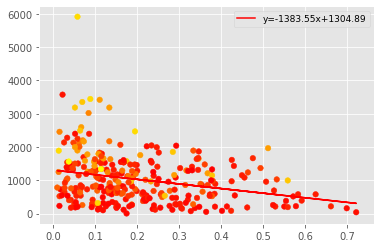

In [78]:
#regression part
x2 = start_station['miles']
y2 = start_station['counts']
a, b = 0, 1
x, y = start_station['Sum of 2015_Rides'].min(), start_station['Sum of 2015_Rides'].max()
start_station['Scaled_ridership'] = (start_station['Sum of 2015_Rides'] - x) / (y - x) * (b - a) + a
z2 = start_station['Scaled_ridership']
#colors = plt.cm.coolwarm(scaled_ridership)

slope, intercept, r_value, p_value, std_err = stats.linregress(x2,y2)

line = slope*x2+intercept
plt.plot(x2, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
#end

#plt.ylim(0, 3000)
plt.scatter(x2, y2, c=z2, s=30.5, cmap=plt.cm.autumn)
plt.legend(fontsize=9)

plt.show()

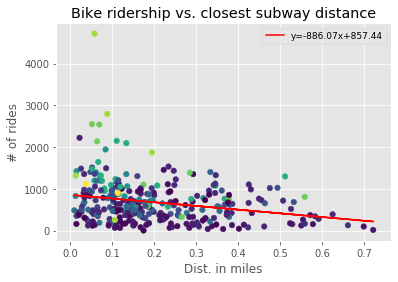

In [79]:
#regression part
x2 = start_station_peak['miles']
y2 = start_station_peak['counts']
a, b = 0, 1
x, y = start_station_peak['Sum of 2015_Rides'].min(), start_station_peak['Sum of 2015_Rides'].max()
start_station_peak['Scaled_ridership'] = (start_station_peak['Sum of 2015_Rides'] - x) / (y - x) * (b - a) + a
z2 = start_station_peak['Scaled_ridership']
#colors = plt.cm.coolwarm(scaled_ridership)

slope, intercept, r_value, p_value, std_err = stats.linregress(x2,y2)

line = slope*x2+intercept
plt.plot(x2, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
#end

#plt.ylim(0, 3000)
plt.scatter(x2, y2,c=z2, s=30.5)
plt.xlabel("Dist. in miles")
plt.ylabel("# of rides")
plt.title("Bike ridership vs. closest subway distance")
plt.legend(fontsize=9)

plt.show()

In [80]:
df.shape

(341826, 21)